# Calibrazione della camera

In questo foglio affronteremo uno dei passaggi cardine quando si lavora con una camera: la correzione degli distorsioni!  
Bisogna infatti sapere che la maggior parte delle fotocamere introduce una significativa distorsione alle immagini che cattura, le due più importanti sono 

1. **la distorsione radiale**
2. **distorsione tangenziale**

La prima causa alle linee rette di apparire curve e aumenta man mano che ci si allontana dal centro dell'immagine *(immagine di sinistra)*, mentre la seconda è data dal fatto che il piano della lente non è parallelo al piano dell'immagine *(immagine di destra)*.

![](part1/img/camera_prob3.png)

La procedura che va a calcolare i parametri relativi a questi errori per darci una matrice e dei coefficienti di correzione è detta **calibrazione**

## Teoria dietro la calibrazione della camera

Per comprendere appieno il codice che andremo ad eseguire più tardi è giusto introdurre un po' di teoria; questa non è obbligatoria in quanto opencv semplifica molte funzioni, ma saperla ci permetterà di comprendere la motivazione dietro molti passaggi.

Matematicamente il comportamento di una fotocamera è descritto da quello che viene chiamato [**pinhole model**](https://en.wikipedia.org/wiki/Pinhole_camera_model);

![](part1/img/pinhole.png)

Questo suppone che tutta la luce che la camera riceve passi da un'apertura piccolissima (**pinhole**), ma nella realtà questo porterebbe ad immagini con poca risoluzione.  
Per questo si utilizzano **lenti** unite a **sensori CMOS** per la cattura della luce, ma questo introduce delle variazioni rispetto al modello originale.  
Un esempio può essere una lunghezza focale sull'asse x diversa da quella sull'asse y, oppure un allineamento non perfetto del centro del sensore di luce con quello della lente.

Tutti questi problemi aggiuntivi vengono modellizzati dalla **matrice di calibrazione intrinseca**

![](part1/img/matrix.png)

1. **fx** e **fy** rappresentano le lunghezze focali (in pixel).
2. **cx** e **cy** rappresentano il centro ottico (proiezione del centro del sistema della camera sull'immagine)

Inoltre come detto prima avremo delle distorsioni (radiali e tangenziali) dovute alla lente e queste verranno modellizzate da queste formule matematiche:

![](part1/img/formule.png)

I parametri k e p saranno i **coefficienti di distorsione** che dovremo andare a ricavare insieme alla matrice di calibrazione intrinseca.

Per maggior approfondimento, ecco il paper che propose l'idea del metodo di calibrazione che andremo ad effettuare:

Zhengyou Zhang, [A Flexible New Technique for Camera Calibration](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf), Technical Report MSR-TR-98-71, Microsoft Research, 1998.

## Pratica e codice

Per questo corso ti servirà anche stampare la scacchiera che troverai nel materiale di questo modulo. Questa risulta uno strumento perfetto in quando ci fornisce dei punti facilmente individuabili e dalle coordinate relative ben definite. Sarà inoltre importante che questa rimanga ben piatta, consigliamo quindi di incollarla ad una superficie solida (ex. cartoncino duro).

Cominciamo a programmare, importiamo innanzitutto le librerie necessarie:

In [1]:
import cv2
import glob
import numpy as np
import yaml
import time

Andiamo ora a creare delle variabili che rappresentano i dati della nostra scacchiera, in particolare nx ed ny non rappresenteranno il numero di caselle ma il numero di spigoli interni alla scacchiera. Lo square_size, ovvero la dimensione del lato dei quadrati della scacchiera dovrà essere in metri.

![](part1/img/chessboard_example.png)


In [2]:
nx = 9
ny = 7
square_size = 0.02

Creaimo gli array che conserveranno le coordinate dei punti di interesse della scacchiera. **imgpoint** conterrà le coordinate dei punti rilevati nelle foto, mentre **objpoints** conserverà i punti nello spazio 3D, queste ultime coordinate saranno molto semplici dato che consideriamo la scacchiera piana e a terra (Z = 0), quindi avremo punti del tipo (0,0,0), (0.018,0,0),...

***TIPS**: Quando conosci già le caratteristiche di un determinato array (dimensione e tipo) è bene dichiaralo subito in modo da preallocare la memoria e migliorare così la performance del codice.*

In [15]:
objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
objp = objp * square_size

imgpoints = []
objpoints = []

Andiamo ora ad importare le foto scattate per la calibrazione. Se si vuole ottenere un'effettivo file di calibrazione per la propria camera bisognerebbe usare foto scattate da questa. Alla fine di questo modulo si troverà un programma per poter effettuare questo lavoro, al momento a scopo dimostrativo useremo quelle di una picamera V2.

In [5]:
images = glob.glob('part1/chessboards/*.jpg')

La funzione **findChessboardCorners** di opencv si occupa di trovare i punti della scacchiera nelle immagini e ritornerà due variabili:  
1) **ret**: variabil booleane (True o False) che ci dice se sono stati trovati punti.
2) **corners**: array contenente le coordinate dei pixel dell'immagine associati ai punti trovati (se trovati).

Andremo poi a migliorare la precisione delle coordinate dei punti trovati con la funzione **cornerSubPix** e infine li aggiungeremo alla lista **imgpoints**.

**Nota:** dichiarare una variabile come *var = []* in python, vuol dire dichiarare una particolare struttura dati chiamata lista. Vedi [liste python](https://www.w3schools.com/python/python_lists.asp)

In [16]:
#se avete finito il tutorial e avete già fatto le vostre foto, rirunnate da qui
 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

Ora che abbiamo tutte le informazioni necessarie andiamo a calcolare le matrici e i coefficienti di nostro interesse tramite la funzione **calibrateCamera**.  
Al fine di correggere le distorsioni della fotocamera ci interesseranno solo **matrix** e **distortion_coeff**.

In [18]:
ret, matrix, distortion_coeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

e ora andiamo a salvare la matrice e l'array di coefficienti in un file **yaml**, questo ci permetterà di tenerle salvate per futuri utilizzi.

**NOTA**: *il formato di file yaml è altamente diffuso come strumento di gestione delle configurazioni per via della sua semplicità di lettura (human-friendly), se vuoi saperne di più leggi qua:*  [spiegazione](https://www.redhat.com/it/topics/automation/what-is-yaml)

In [ ]:
calibration_data = {
    "camera_matrix": matrix,
    "distortion_coeff": distortion_coeff
}

with open('part1/FinalCalibrationPersonal.yml', 'w') as outfile:
    yaml.dump(calibration_data, outfile, default_flow_style = False)

Questo file di calibrazione ci servirà per tutti i futuri moduli! Finora avete utilizzato foto fornite da noi, però se voleste effettuare una calibrazione precisa sarebbe meglio che utilizzaste delle vostre foto, e ora vi spiegherò come.

Prendete la scacchiera che avete stampato e posizionatela davanti alla camera, cambiando posizione ed angolazione ad ogni foto fatta. Assicuratevi comunque che questa si veda bene nella preview.

andremo inoltre ad importare una libreria necessaria per l'utilizzo della camera per chi sta seguendo questo tutorial da raspberry con una picamera

In [3]:
from picamera import PiCamera

Ora andremo a runnare il programma che scatterà le foto, questa lascierà qualche secondo di preview per permettere il cambio di posizione della schacchiera.
Scatteremo 15 foto in modo da aumentare il numero di possibili foto buone. Per chi stesse usando una picamera la casella è la prima, mentre per chi stesse usando una camera USB la seconda

In [11]:
#programma per picamera raspberry pi

camera = PiCamera()
for i in range(10):
    print("avvio camera")
    camera.start_preview()
    print("foto numero {}".format(i))
    print("foto tra 2 secondi")
    time.sleep(2)
    photo_name = "part1/foto/foto" + str(i) + ".jpg"
    camera.capture(photo_name)
    i=i+1
    camera.stop_preview()
print("fine")
camera.close()

avvio camera
foto numero 0
foto tra 2 secondi
avvio camera
foto numero 1
foto tra 2 secondi
avvio camera
foto numero 2
foto tra 2 secondi
avvio camera
foto numero 3
foto tra 2 secondi
avvio camera
foto numero 4
foto tra 2 secondi
avvio camera
foto numero 5
foto tra 2 secondi
avvio camera
foto numero 6
foto tra 2 secondi
avvio camera
foto numero 7
foto tra 2 secondi
avvio camera
foto numero 8
foto tra 2 secondi
avvio camera
foto numero 9
foto tra 2 secondi


Il programma per chi usa una USB camera:

In [ ]:
#programma per camera nativa o USB

cam = cv2.VideoCapture(0)
for i in range(10):
    print("avvio camera")
    print("foto numero {}".format(i))
    print("foto tra 2 secondi")
    time.sleep(2)
    ret, image = cam.read()
    photo_name = "part1/foto/foto" + str(i) + ".jpg"
    cv2.imwrite(photo_name, image)
    i=i+1
cam.release()

controlliamo ora quante foto buone sono state scattate.

part1/chessboards/foto1.jpg


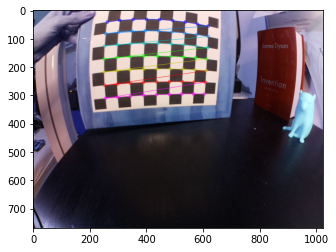

 
part1/chessboards/foto2.jpg


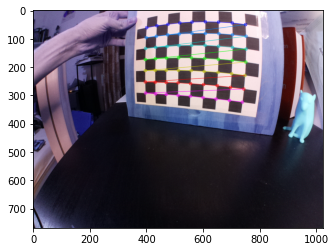

 
part1/chessboards/foto9.jpg


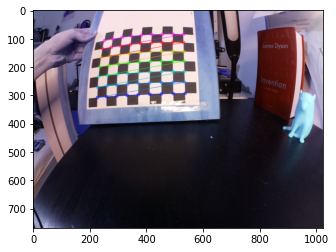

 
part1/chessboards/foto5.jpg


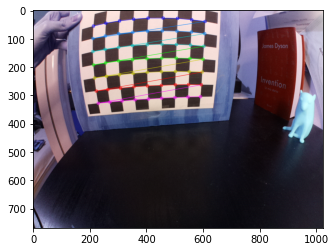

 
part1/chessboards/foto6.jpg


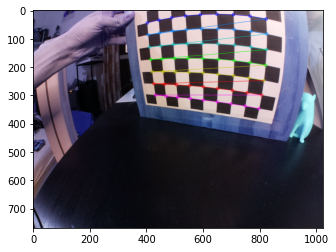

 
part1/chessboards/foto3.jpg


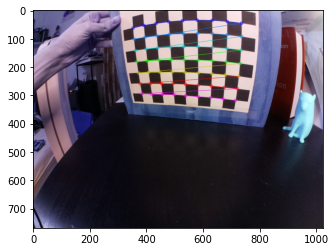

 
part1/chessboards/foto7.jpg


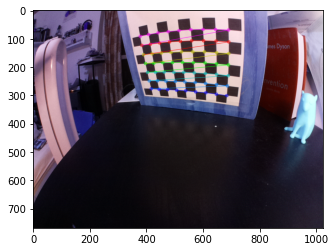

 
part1/chessboards/foto4.jpg


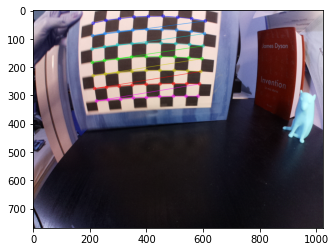

 
part1/chessboards/foto0.jpg


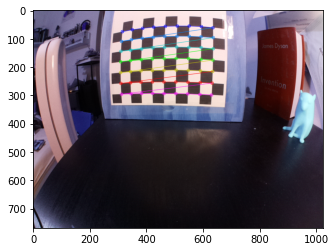

 
part1/chessboards/foto8.jpg


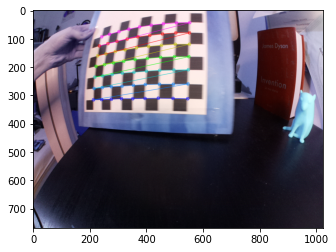

 
numero di foto buone: 10


In [27]:
import matplotlib.pyplot as plt

total = 0

images = glob.glob('part1/foto/*.jpg')

for fname in images:
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        image = np.copy(img)
        cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
        plt.imshow(image)
        plt.show()
        time.sleep(2)
        total = total + 1
    else:
        print("foto andata male! RIPROVA")
    i = i +1
    print(" ")
print("numero di foto buone: {}".format(total))

Se il numero di foto buone è almeno 10 procedete a runnare la casella successiva e poi rirunnate le caselle a partire da quella che inizia con criteria.

In caso solo alcune delle foto non siano venute bene è possibile creare una casella uguale a quella dello scattare foto ma senza ciclo for!

In [ ]:
images = glob.glob('part1/foto/*.jpg')